In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention as described in the ViT paper"""
    def __init__(self, scale):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
    
    def forward(self, q, k, v, mask=None):
        # q, k, v shape: [batch_size, head, seq_len, dim]
        # Calculate attention scores
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply attention weights to values
        output = torch.matmul(attention_weights, v)
        
        return output, attention_weights

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention as described in the ViT paper"""
    def __init__(self, dim_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.dim_model = dim_model
        
        assert dim_model % num_heads == 0, "dim_model must be divisible by num_heads"
        
        self.depth = dim_model // num_heads
        
        # Linear projections
        self.wq = nn.Linear(dim_model, dim_model)
        self.wk = nn.Linear(dim_model, dim_model)
        self.wv = nn.Linear(dim_model, dim_model)
        
        self.attention = ScaledDotProductAttention(scale=self.depth ** -0.5)
        
        self.fc_out = nn.Linear(dim_model, dim_model)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]
        
        # Linear projections and reshape
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # Scaled dot-product attention
        output, _ = self.attention(q, k, v, mask)
        
        # Reshape back and project
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_model)
        output = self.fc_out(output)
        
        return output

class TransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer as described in the ViT paper"""
    def __init__(self, dim_model, num_heads, dim_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.mha = MultiHeadAttention(dim_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, dim_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Layer norm and multi-head attention (Pre-LN architecture)
        attn_output = self.mha(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Layer norm and feed forward
        ff_output = self.ffn(self.norm2(x))
        # Residual connection
        x = x + ff_output
        
        return x
        
class VisionTransformer(nn.Module):
    """Vision Transformer (ViT) as described in the paper"""
    def __init__(self, 
                 image_size=32,       # CIFAR-10 image size
                 patch_size=4,        # as specified
                 in_channels=3,       # RGB images
                 num_classes=10,      # CIFAR-10 has 10 classes
                 dim_model=192,       # embedding dimension
                 num_heads=8,         # number of heads in multihead attention
                 num_encoder_layers=8, # number of transformer encoder layers
                 dim_ff=768,          # feed-forward network dimension
                 dropout=0.1):        # dropout rate
        super(VisionTransformer, self).__init__()
        
        # Image and patch parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # Calculate the number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        
        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(patch_dim, dim_model)
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim_model))
        
        # Positional embedding for patches + class token
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, dim_model))
        
        # Dropout after position embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(dim_model, num_heads, dim_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        
        # Layer normalization
        self.ln = nn.LayerNorm(dim_model)
        
        # MLP Head for classification
        self.mlp_head = nn.Linear(dim_model, num_classes)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        # Initialize patch embedding like a linear layer
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        
        # Initialize cls token
        nn.init.xavier_normal_(self.cls_token)
        
        # Initialize position embedding
        nn.init.normal_(self.pos_embedding, std=0.02)
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.shape[0]
        
        # Extract patches: [B, C, H, W] -> [B, num_patches, C*P*P]
        # Where P is the patch size
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.in_channels, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.in_channels * self.patch_size * self.patch_size)
        
        # Linear embedding of patches
        x = self.patch_embedding(x)  # [B, num_patches, dim_model]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, dim_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+num_patches, dim_model]
        
        # Add positional embedding
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Apply transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Apply layer normalization
        x = self.ln(x)
        
        # Take the cls token representation
        x = x[:, 0]  # [B, dim_model]
        
        # Classification head
        x = self.mlp_head(x)  # [B, num_classes]
        
        return x

def get_data_loaders(batch_size=128):
    """Create CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Create a validation set
    val_size = 5000
    train_size = len(trainset) - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42))
    
    valloader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_subset_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_subset_loader, valloader, testloader


# 1.4.2

Files already downloaded and verified


/tmp/ipykernel_31/4269846885.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


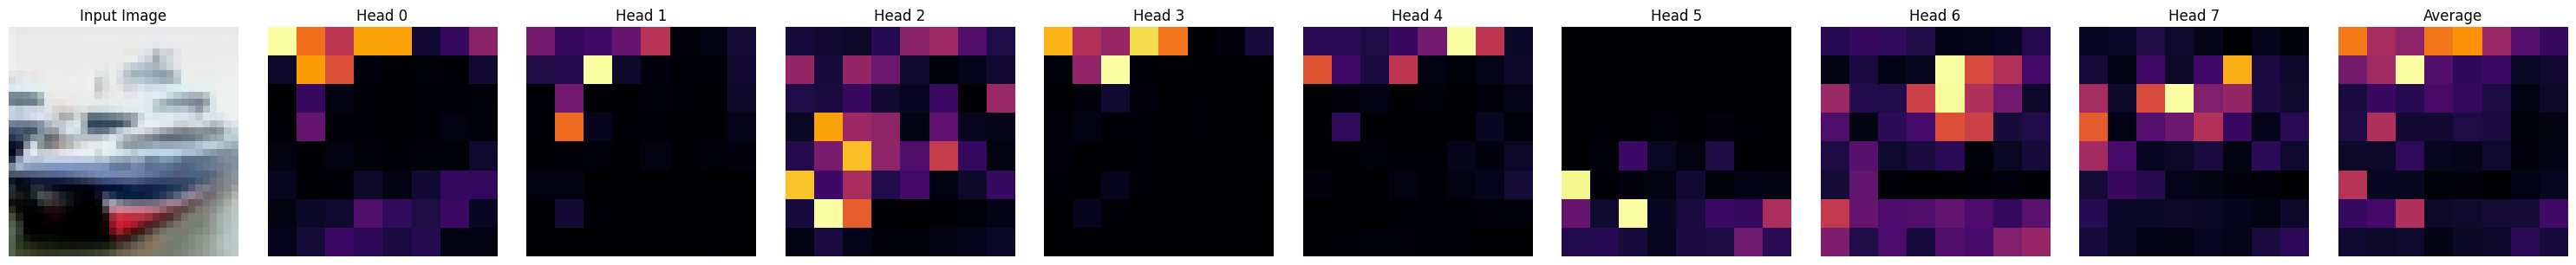

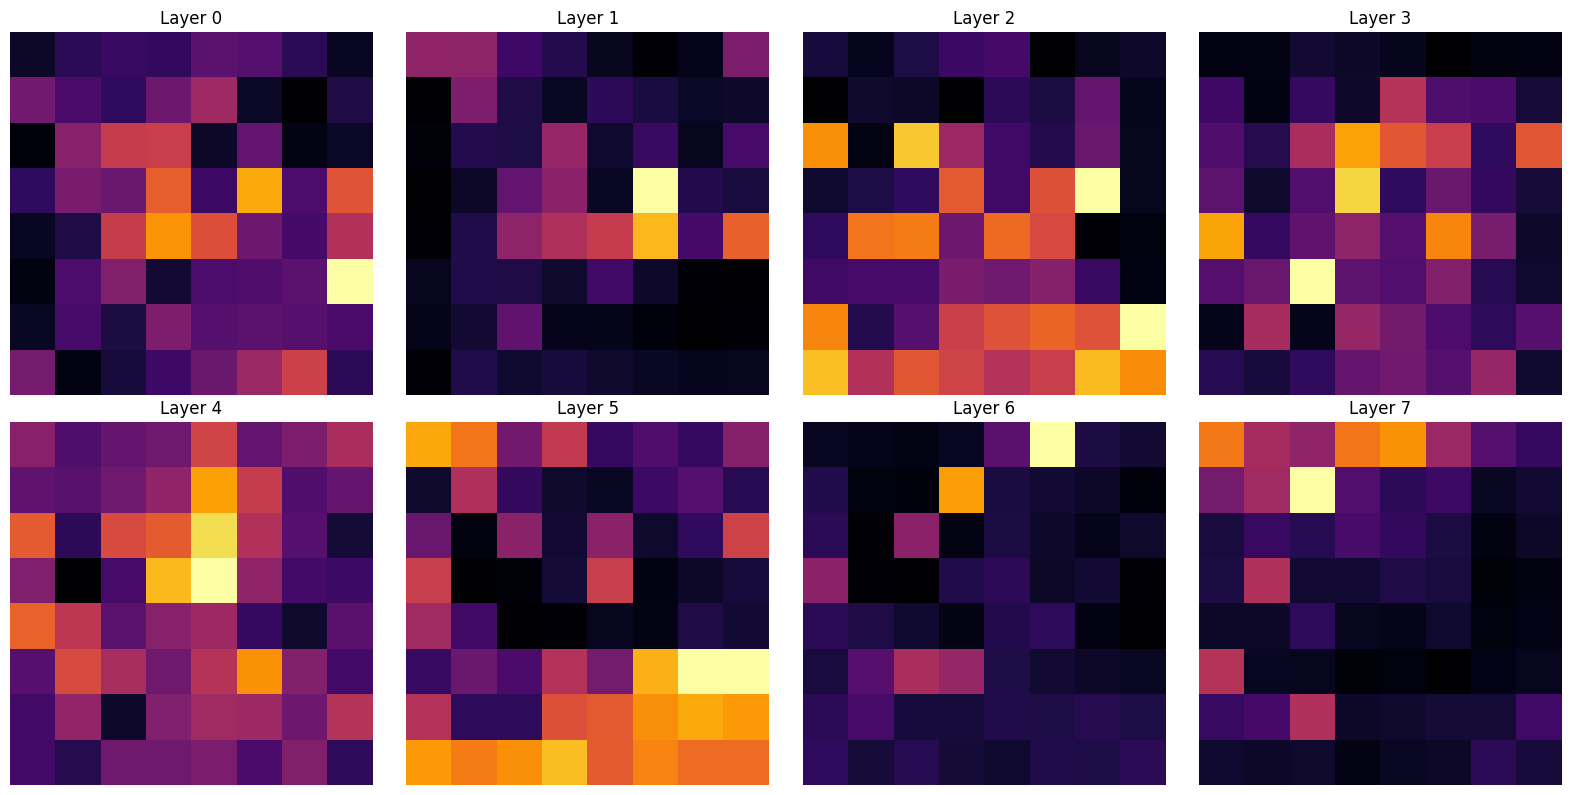

In [4]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ─── 1. HYPERPARAMS & PATHS ───────────────────────────────────────────────
MODEL_PATH = "/kaggle/input/models/best_vit_model.pth"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2. DATA ─────────────────────────────────────────────────────────────
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ─── 3. MODEL ────────────────────────────────────────────────────────────
# Make sure you've already run your ViT‐definition cell, so these classes exist!
model = VisionTransformer(
    image_size=32, patch_size=4, in_channels=3,
    num_classes=10, dim_model=192, num_heads=8,
    num_encoder_layers=8, dim_ff=768, dropout=0.1
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# ─── 4. HOOKS TO CAPTURE ATTENTION WEIGHTS ───────────────────────────────
# We'll store, for each layer index, the raw attention matrix of shape
# [batch, heads, seq_len, seq_len].
attention_maps = {}

def get_hook(layer_idx):
    def hook(module, inp, out):
        # out is a tuple: (attended_values, attention_weights)
        attn = out[1]  # [B, heads, seq_len, seq_len]
        attention_maps[layer_idx] = attn.detach().cpu()
    return hook

# Register a hook on each scaled‐dot‐product‐attention in each encoder layer
for idx, enc_layer in enumerate(model.encoder_layers):
    enc_layer.mha.attention.register_forward_hook(get_hook(idx))

# ─── 5. RUN ONE FORWARD PASS ON A BATCH ─────────────────────────────────
# We'll grab the first batch, but you can loop over several if you want.
images, labels = next(iter(test_loader))
images = images.to(DEVICE)
_ = model(images)   # this populates `attention_maps`

# ─── 6. VISUALIZE LAST LAYER, PER‐HEAD + AGGREGATED ─────────────────────
last_idx = len(model.encoder_layers) - 1
attn_last = attention_maps[last_idx]  # [B, heads, seq, seq]

# Select image 0 in batch
attn0 = attn_last[0]                  # [heads, seq, seq]
num_heads, seq_len, _ = attn0.shape
num_patches = seq_len - 1             # subtract the CLS token
grid_size = int(np.sqrt(num_patches)) # e.g. 8 for 32×32 / 4

# CLS→patch attention is at [:, 0, 1:]
cls2patch = attn0[:, 0, 1:]           # [heads, num_patches]

# Prepare the raw image for display (undo normalize)
img = images[1].cpu().permute(1,2,0).numpy()
mean = np.array([0.4914,0.4822,0.4465])
std  = np.array([0.2470,0.2435,0.2616])
img = (img * std) + mean
img = np.clip(img, 0, 1)

fig, axes = plt.subplots(1, num_heads+2, figsize=(3*(num_heads+2), 3))
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis('off')

# Each head
for h in range(num_heads):
    attn_map = cls2patch[h].reshape(grid_size, grid_size).numpy()
    ax = axes[h+1]
    ax.imshow(attn_map, cmap='inferno')
    ax.set_title(f"Head {h}")
    ax.axis('off')

# Aggregated (mean over heads)
agg = cls2patch.mean(0).reshape(grid_size, grid_size).numpy()
ax = axes[-1]
ax.imshow(agg, cmap='inferno')
ax.set_title("Average")
ax.axis('off')

plt.tight_layout()
plt.show()

# ─── 7. VISUALIZE AGGREGATED CLS→PATCH FOR ALL LAYERS ────────────────────
n_layers = len(model.encoder_layers)
cols = 4
rows = int(np.ceil(n_layers/cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
for idx in range(n_layers):
    row, col = divmod(idx, cols)
    attn = attention_maps[idx][0]         # [heads, seq, seq]
    cls2p = attn[:, 0, 1:].mean(0)        # mean over heads → [num_patches]
    attn_map = cls2p.reshape(grid_size, grid_size).numpy()
    ax = axes[row, col]
    ax.imshow(attn_map, cmap='inferno')
    ax.set_title(f"Layer {idx}")
    ax.axis('off')

# Turn off any unused subplots
for idx in range(n_layers, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


## 1.4.3

Files already downloaded and verified


/tmp/ipykernel_31/3093220246.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


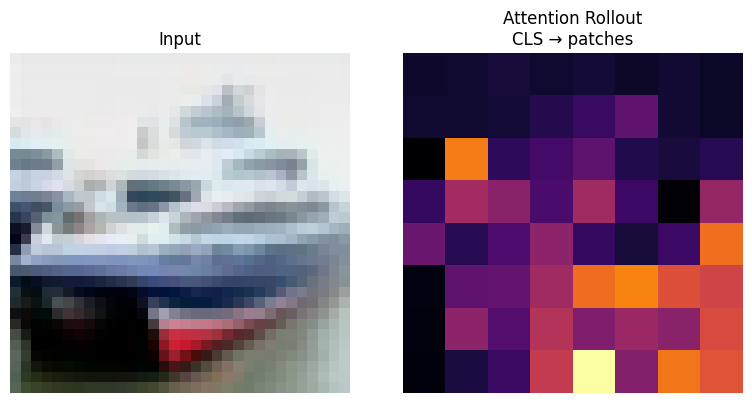

In [5]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ─── 1. HYPERPARAMS & PATH ───────────────────────────────────────────────
MODEL_PATH = "/kaggle/input/models/best_vit_model.pth"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2. CIFAR‑10 TEST DATA ────────────────────────────────────────────────
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ─── 3. LOAD YOUR ViT MODEL ───────────────────────────────────────────────
# (Assumes you’ve already run the cell defining VisionTransformer, etc.)
model = VisionTransformer(
    image_size=32, patch_size=4, in_channels=3,
    num_classes=10, dim_model=192, num_heads=8,
    num_encoder_layers=8, dim_ff=768, dropout=0.1
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# ─── 4. HOOK IN RAW ATTENTION WEIGHTS ────────────────────────────────────
# Will collect raw [B, heads, seq, seq] per layer
raw_attns = {}

def get_attn_hook(layer_idx):
    def hook(module, inp, out):
        # out = (attended_vals, attn_weights)
        raw_attns[layer_idx] = out[1].detach().cpu()
    return hook

for idx, enc in enumerate(model.encoder_layers):
    enc.mha.attention.register_forward_hook(get_attn_hook(idx))

# ─── 5. RUN A SINGLE BATCH ────────────────────────────────────────────────
imgs, _ = next(iter(test_loader))
imgs = imgs.to(DEVICE)
_ = model(imgs)   # populates raw_attns

# ─── 6. COMPUTE ATTENTION‑ROLLOUT ────────────────────────────────────────
# pick the first image in batch
batch_i = 1
num_layers = len(model.encoder_layers)
# seq_len = 1 (CLS) + num_patches; patches = (32/4)^2 = 64 → seq_len = 65
seq_len = raw_attns[0].shape[-1]

# initialize joint attention to identity
joint = torch.eye(seq_len)

for i in range(num_layers):
    attn = raw_attns[i][batch_i]    # [heads, seq, seq]
    # average over heads
    attn_fused = attn.mean(dim=0)   # [seq, seq]
    # add identity (residual) and re‑normalize rows
    attn_res = attn_fused + torch.eye(seq_len)
    attn_res = attn_res / attn_res.sum(dim=-1, keepdim=True)
    # accumulate
    joint = attn_res @ joint        # [seq, seq]

# now joint[a,b] holds cumulative attn from token a to b
# we want from CLS (0) → all patch tokens (1:)
rollout_map = joint[0, 1:]         # [num_patches]
# reshape into 8×8 grid
grid_size = int(np.sqrt(rollout_map.shape[0]))
rollout_map = rollout_map.reshape(grid_size, grid_size).numpy()

# ─── 7. PREPARE & PLOT ───────────────────────────────────────────────────
# undo normalization on the input image
img = imgs[batch_i].cpu().permute(1,2,0).numpy()
mean = np.array([0.4914,0.4822,0.4465])
std  = np.array([0.2470,0.2435,0.2616])
img = np.clip(img * std + mean, 0, 1)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(img)
axes[0].set_title("Input")
axes[0].axis('off')

axes[1].imshow(rollout_map, cmap='inferno', interpolation='nearest')
axes[1].set_title("Attention Rollout\nCLS → patches")
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 1.4.4

/tmp/ipykernel_31/3492491654.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Retrieved 65 positional embeddings (dim=192)


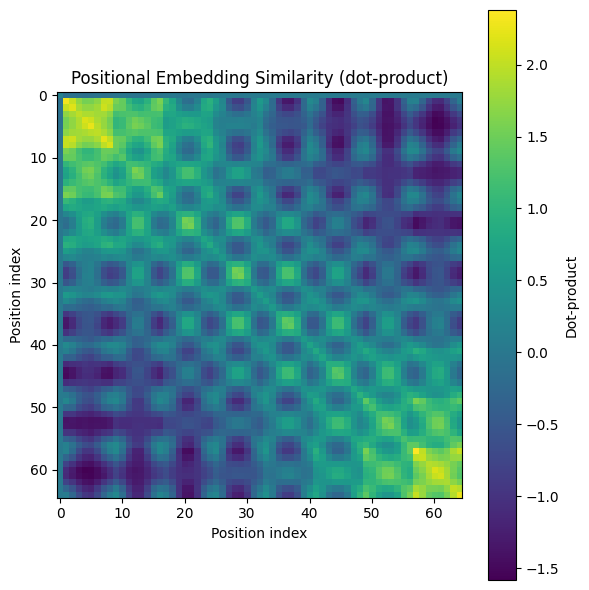

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ─── 1. SETUP ─────────────────────────────────────────────────────────────
MODEL_PATH = "/kaggle/input/models/best_vit_model.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2. LOAD YOUR ViT ────────────────────────────────────────────────────
# (Make sure the class definitions for VisionTransformer et al. are in scope)
model = VisionTransformer(
    image_size=32, patch_size=4, in_channels=3,
    num_classes=10, dim_model=192, num_heads=8,
    num_encoder_layers=8, dim_ff=768, dropout=0.1
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# ─── 3. EXTRACT POSITIONAL EMBEDDINGS ───────────────────────────────────
# pos_embedding is of shape [1, num_patches+1, dim_model]
pos_emb = model.pos_embedding.squeeze(0)       # → [num_positions, dim_model]
num_pos, dim_model = pos_emb.shape
print(f"Retrieved {num_pos} positional embeddings (dim={dim_model})")

# ─── 4. COMPUTE PAIRWISE DOT‑PRODUCT SIMILARITY ──────────────────────────
# similarity[i,j] = <pos_emb[i], pos_emb[j]>
with torch.no_grad():
    sim = pos_emb @ pos_emb.t()                # → [num_positions, num_positions]
sim = sim.cpu().numpy()

# ─── 5. PLOT HEATMAP ─────────────────────────────────────────────────────
plt.figure(figsize=(6,6))
plt.imshow(sim, cmap='viridis', interpolation='nearest')
plt.title("Positional Embedding Similarity (dot‑product)")
plt.xlabel("Position index")
plt.ylabel("Position index")
plt.colorbar(label="Dot‑product")
plt.tight_layout()
plt.show()
